# Investment Theory - Markowitz + Index + TB

## 本文載入的csv欄位 - 股票n支+y999加權指數+MB64(Y)無風險利率 (n不限、Rows不限)
需要手動輸入：raw data檔名、預期報酬

In [341]:
#Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.optimize import linprog

## The raw data

In [342]:
ReturnMonthly = pd.read_excel("template.xlsx", skiprows=1, index_col='年月日')
ReturnMonthly["MB64(M)"] = ReturnMonthly["MB64(Y)"]/12
ReturnMonthly.head()


,1259 安心,1477 聚陽,1784 訊聯,2301 光寶科,2451 創見,0050 元大台灣50,MB64(Y),MB64(M)
年月日,,,,,,,,
2013-10-31,1.9609,19.5286,-5.1936,1.9843,-0.3224,6.2500,0.88,0.0733333333
2013-11-29,-2.4360,-6.4789,-1.1814,-6.5174,-5.0646,0.4668,0.88,0.0733333333
2013-12-31,-3.9421,-3.0122,1.9564,-0.5205,-2.7243,1.4869,0.88,0.0733333333
2014-01-27,-1.0944,-7.7640,-7.4627,-6.1717,5.2508,1.0988,0.88,0.0733333333
2014-02-27,-1.7980,11.7846,9.6775,-0.6690,2.4393,-0.1811,0.88,0.0733333333


## Convert Return to Excess Return

In [343]:
ExcessMonthlyReturn = ReturnMonthly.iloc[:,0:-2]  #第一行到最後第三行(扣掉倒數兩行)(只有股票＋元大)
for column in ExcessMonthlyReturn:
    ExcessMonthlyReturn[column] = (ExcessMonthlyReturn[column] - ReturnMonthly['MB64(M)'])/100 #改成報酬“率”
ExcessMonthlyReturn.head()


,1259 安心,1477 聚陽,1784 訊聯,2301 光寶科,2451 創見,0050 元大台灣50
年月日,,,,,,
2013-10-31,0.0188756667,0.1945526667,-0.0526693333,0.0191096667,-0.0039573333,0.0617666667
2013-11-29,-0.0250933333,-0.0655223333,-0.0125473333,-0.0659073333,-0.0513793333,0.0039346667
2013-12-31,-0.0401543333,-0.0308553333,0.0188306667,-0.0059383333,-0.0279763333,0.0141356667
2014-01-27,-0.0116773333,-0.0783733333,-0.0753603333,-0.0624503333,0.0517746667,0.0102546667
2014-02-27,-0.0187133333,0.1171126667,0.0960416667,-0.0074233333,0.0236596667,-0.0025443333


# Part 1: Markowitz 
Let's start with the markowitz model, that is to say, use the covariance matrix as it is. 

## Monthly Covariance Matrix
The function `.cov()` returns the covariance matrix for a dataframe.	

In [344]:
Stocks = ExcessMonthlyReturn.iloc[:,0:-1]  #只有股票(暫時不用元大)
MonthlyCovMatrix = Stocks.cov()
MonthlyCovMatrix

,1259 安心,1477 聚陽,1784 訊聯,2301 光寶科,2451 創見
1259 安心,0.0028082972,0.0006380516,0.0002883937,0.0000733336,0.0003710545
1477 聚陽,0.0006380516,0.0054605777,0.0001162240,0.0001833769,0.0003145912
1784 訊聯,0.0002883937,0.0001162240,0.0061587790,0.0012954735,0.0006080234
2301 光寶科,0.0000733336,0.0001833769,0.0012954735,0.0034500906,0.0010484126
2451 創見,0.0003710545,0.0003145912,0.0006080234,0.0010484126,0.0027499781


## Yearly Covariance Matrix

In [345]:
YearlyCovMatrix = MonthlyCovMatrix * 12
YearlyCovMatrix

,1259 安心,1477 聚陽,1784 訊聯,2301 光寶科,2451 創見
1259 安心,0.0336995664,0.0076566195,0.0034607240,0.0008800037,0.0044526545
1477 聚陽,0.0076566195,0.0655269320,0.0013946883,0.0022005224,0.0037750948
1784 訊聯,0.0034607240,0.0013946883,0.0739053485,0.0155456819,0.0072962809
2301 光寶科,0.0008800037,0.0022005224,0.0155456819,0.0414010874,0.0125809507
2451 創見,0.0044526545,0.0037750948,0.0072962809,0.0125809507,0.0329997369


# Portfolios, Efficient Frontier, and the CAL

In [346]:
import cvxopt as opt
import scipy.optimize as sco
from cvxopt import blas, solvers
from numpy import array

# Turn off progress printing 
solvers.options['show_progress'] = False

## 注意：請自行輸入外生給定的returns(本題為輸入預期報酬，再扣掉無風險利率)

In [347]:
#n_assets = len(list(ExcessMonthlyReturn.iloc[:,0:-1]))
returns_annual = pd.Series([0.18,
0.12,
0.15,
0.11,
0.09,
])
returns_annual = returns_annual - 0.007

num_assets = len(returns_annual)
print("Number of assets: ",num_assets)

Number of assets:  5


## Maximize the Sharpe Ratio
Following the steps from [this article](http://www.bradfordlynch.com/blog/2015/12/04/InvestmentPortfolioOptimization.html).

In [348]:
def calcPortfolioPerf(weights, meanReturns, covMatrix):
    '''
    weights: list 
    meanReturns: list
    covMatrix: .cov()
    '''
    #Calculate return and variance
    portReturn = np.sum( meanReturns*weights )
    portStdDev = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights)))

    return portReturn, portStdDev

def negSharpeRatio(weights, meanReturns, covMatrix, riskFreeRate):
    '''
    weights: list
    meanReturns: list
    covMatrix: .cov()
    riskFreeRate: constant
    '''
    p_ret, p_var = calcPortfolioPerf(weights, meanReturns, covMatrix)

    return -(p_ret - riskFreeRate) / p_var

def findMaxSharpeRatioPortfolio(meanReturns, covMatrix, riskFreeRate,short):
    '''
    meanReturns: list
    covMatrix: .cov()
    riskFreeRate: constant
    short: True/False to indicate whether short sale is allowed
    '''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    if short == True:
        bounds = tuple( (-10,10) for asset in range(numAssets))
    else:
        bounds = tuple( (0,1) for asset in range(numAssets))

    opts = sco.minimize(negSharpeRatio, numAssets*[1./numAssets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)

    return opts

### Markowitz - Max Sharpe Ratio with shortsale

In [349]:
expected_return = returns_annual.tolist()
maxSharpe_s = findMaxSharpeRatioPortfolio(expected_return,YearlyCovMatrix,0,True)
sharpe_rp_s, sharpe_sdp_s = calcPortfolioPerf(maxSharpe_s['x'], expected_return, YearlyCovMatrix)

sharpe_ratio_s = sharpe_rp_s / sharpe_sdp_s

print("The max sharpe ratio is",sharpe_ratio_s)
print("The expected return is",sharpe_rp_s)
print("")
for i in maxSharpe_s['x']:
     print('%.015f' % i)

The max sharpe ratio is 1.1555689186490516
The expected return is 0.1419268883511789

0.489362869082453
0.112130169196708
0.135876297364486
0.168387360799386
0.094243303556967


### Markowitz - Max Sharpe Ratio without shortsale

In [350]:
#max sharpe ratio without shortsale
expected_return = returns_annual.tolist()
maxSharpe_n = findMaxSharpeRatioPortfolio(expected_return,YearlyCovMatrix,0,False)
sharpe_rp_n, sharpe_sdp_n = calcPortfolioPerf(maxSharpe_n['x'], expected_return, YearlyCovMatrix)

sharpe_ratio_n = sharpe_rp_n / sharpe_sdp_n

for i in maxSharpe_n['x']:
     print('%.015f' % i)
print("")
print("The max sharpe ratio is",sharpe_ratio_n)
print("The expected return is",sharpe_rp_n)

0.489362453585216
0.112132812222233
0.135880458879072
0.168383251559077
0.094241023754402

The max sharpe ratio is 1.1555689189670848
The expected return is 0.1419270977532623


## Efficient Frontier and the Min Variance Portfolio
To know more about how **solvers.qp()** works: https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf

In [351]:
def efficient_frontier_and_min_var(returns, covmatrix, short):
    n = len(returns)
    p = np.asmatrix(returns)
    C = np.asmatrix(covmatrix)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(C)
    pbar = opt.matrix(p.T)
    
    # Create constraint matrices
    if short == True:
        G = opt.matrix(np.eye(n))   
        h = opt.matrix(1.5, (n ,1))
    else:
        G = -opt.matrix(np.eye(n))
        h = opt.matrix(0.0,(n,1))
    
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    
    #The min var point
    q = opt.matrix(0.0, (n, 1))
    min_portfolio = solvers.qp(S, q, G, h, A, b)['x']  
    min_portfolio = array(min_portfolio).flatten()
    
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    return portfolios, returns, risks, min_portfolio

### Markowitz - Min Var with shortsale

In [352]:
portfolios_s, returns_s, risks_s, minvar_portfolio_s = efficient_frontier_and_min_var(returns_annual,YearlyCovMatrix,True)
minvar_rp_s, minvar_sdp_s = calcPortfolioPerf(minvar_portfolio_s, expected_return, YearlyCovMatrix)


print("The min sd is : ", minvar_sdp_s)
print("The return is : ",minvar_rp_s)
print(" ")
for i in minvar_portfolio_s:
     print('%.015f' % i)


The min sd is :  0.11544041025646937
The return is :  0.1253840105630561
 
0.314846486017362
0.143612794572931
0.097182296154763
0.195425260750991
0.248933162503953


### Markowitz - Min Var without shortsale

In [353]:
portfolios_n, returns_n, risks_n, min_portfolio_n = efficient_frontier_and_min_var(returns_annual,YearlyCovMatrix,False)
minvar_rp_n, minvar_sdp_n = calcPortfolioPerf(min_portfolio_n, expected_return, YearlyCovMatrix)

#print("The min sd is : ", minvar_sdp_n)
#print("The return is : ",minvar_rp_n)
#print(" ")
#for i in min_portfolio_n:
#     print('%.015f' % i)

## Given the Mean, the portfolio with minimum SD?
To know more about how **solvers.qp()** works: https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf

In [354]:
def GivenReturnMinVarPort(ReturnGiven, returns, covmatrix, short):
    n = len(returns)
    p = np.asmatrix(returns)
    C = np.asmatrix(covmatrix)

    # Convert to cvxopt matrices
    S = opt.matrix(C)
    
    # Create constraint matrices
    if short == True:
        G = opt.matrix(np.eye(n))   
        h = opt.matrix(1.5, (n ,1))
    else:
        G = -opt.matrix(np.eye(n))
        h = opt.matrix(0.0,(n,1))
    
    a1 = [1]*n   #1*weights =1 
    a2 =returns.tolist()  #expectedRetrun*weights = ReturnsGiven
    A = opt.matrix(a1+a2, (n,2)).T  #stack two list in a 2xn matrix
    b = opt.matrix([1.0,ReturnGiven],(2,1))   #2xn times nx1 = 2x1 matrix
    
    #The min var point
    q = opt.matrix(0.0, (n, 1))
    portfolios = solvers.qp(S, q, G, h, A, b)['x']  
    portfolios = array(portfolios).flatten()
    
    return portfolios

## To make the df

In [355]:
#portfolio maxSharpe_n['x'] (no shortsale)
MaxSharpe_potfolio_n = np.concatenate([[sharpe_rp_n],[sharpe_sdp_n],[sharpe_ratio_n],maxSharpe_n['x']])
MinVariance_portfolio_n = np.concatenate([[minvar_rp_n],[minvar_sdp_n],[minvar_rp_n/minvar_sdp_n],maxSharpe_n['x']])

#portfolio maxSharpe_s['x']  (shortsale)
MaxSharpe_potfolio_s = np.concatenate([[sharpe_rp_s],[sharpe_sdp_s],[sharpe_ratio_s],maxSharpe_s['x']])
MinVariance_portfolio_s = np.concatenate([[minvar_rp_s],[minvar_sdp_s],[minvar_rp_s/minvar_sdp_s],maxSharpe_s['x']])

## No short sale portfolios
製作需要的excel表格（手動輸入間距）
Rows: 0-Mean, 1-SD, 2-Slope, 3-12-Weights

In [356]:
pd.set_option('precision',10)
GivenReturnList = [0.06,0.07,0.08,0.09,0.11,0.12,0.13,0.14]
l =[]
for i in range(8):  # do 9 times
    GivenReturn = GivenReturnList[i]   #####
    portfolio = GivenReturnMinVarPort(GivenReturn, returns_annual,YearlyCovMatrix,False)  #####
    portfolio_rp, portfolio_sdp = calcPortfolioPerf(portfolio, expected_return, YearlyCovMatrix)
    sharpe = portfolio_rp/portfolio_sdp
    column = [portfolio_rp, portfolio_sdp, sharpe] + portfolio.tolist()
    l.append(column)

data=pd.DataFrame(l).T
data.insert(4, "Optimum", MaxSharpe_potfolio_n)
data.insert(0, "MinVariance", MinVariance_portfolio_n)  #####
#data

## Short sale portfolios
Rows: 0-Mean, 1-SD, 2-Slope, 3-12-Weights

In [357]:
pd.set_option('precision',10)
GivenReturnList = [0.06,0.07,0.08,0.09,0.11,0.12,0.13,0.14]
l =[]
for i in range(8):  # do 9 times
    GivenReturn = GivenReturnList[i]   #####
    portfolio = GivenReturnMinVarPort(GivenReturn, returns_annual,YearlyCovMatrix,True)  #####
    portfolio_rp, portfolio_sdp = calcPortfolioPerf(portfolio, expected_return, YearlyCovMatrix)
    sharpe = portfolio_rp/portfolio_sdp
    column = [portfolio_rp, portfolio_sdp, sharpe] + portfolio.tolist()
    l.append(column)

data=pd.DataFrame(l).T
data.insert(4, "Optimum", MaxSharpe_potfolio_s)
data.insert(0, "MinVariance", MinVariance_portfolio_s)  #####
#data

## Markowitz - Figure

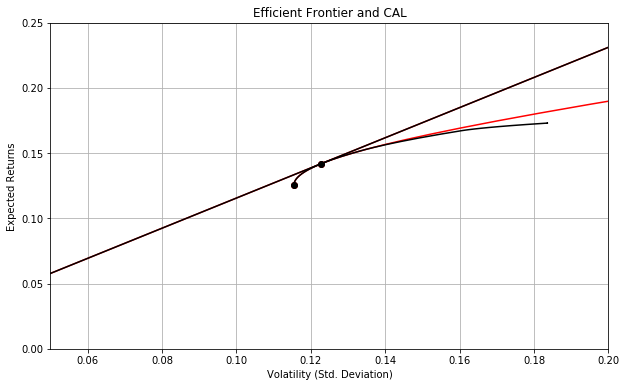

In [358]:
plt.figure(figsize=(10,6))    #更改圖的大小
x = np.linspace(0, 0.3, 1000)
plt.xlim(0.05,0.2)    #更改圖中x之範圍
plt.ylim(0.0,0.25)          #更改圖中y之範圍
plt.plot(x, sharpe_ratio_s*x,'r')  
plt.plot(risks_s, returns_s, 'r')
plt.plot(minvar_sdp_s, minvar_rp_s, 'ro') #min variance portfolio with shortsale
plt.plot(sharpe_sdp_s, sharpe_rp_s, 'ro') #min sharpe ratio portfolio with shortsale

plt.plot(x, sharpe_ratio_n*x,'k')  
plt.plot(risks_n, returns_n, 'k')
plt.plot(minvar_sdp_n, minvar_rp_n, 'ko') #min variance portfolio without shortsale
plt.plot(sharpe_sdp_n, sharpe_rp_n, 'ko') #min sharpe ratio portfolio without shortsale

plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier and CAL')
plt.grid()

plt.show()

# Part 2: Index Model
In the following sessions, we are going to obtain the portfolio using the Index Model. Based on the assumptions, we can derive that 
- $Var(r_i) = \beta_i^2\sigma_m^2 + \sigma^2(e_i)$
- $Cov(r_i,r_j) = \beta_i\beta_j\sigma_m^2$

In [359]:
import statsmodels.api as sm
Y = ExcessMonthlyReturn.iloc[:,0]  #select first column of the dataframe and turn it into numpy array
X = ExcessMonthlyReturn.iloc[:,-1]#select the last column of the dataframe and turn it into numpy array(y9999)
X = sm.add_constant(X)   #要加這項才會有constant（詭異的設定）
results = sm.OLS(Y,X,).fit()
print(results.params)
print(results.summary())

const          0.0012813237
0050 元大台灣50    0.0618217162
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                1259 安心   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                   0.06269
Date:                Wed, 07 Nov 2018   Prob (F-statistic):              0.803
Time:                        18:09:28   Log-Likelihood:                 91.656
No. Observations:                  60   AIC:                            -179.3
Df Residuals:                      58   BIC:                            -175.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

## Run all the regressions to get the betas

In [360]:
import statsmodels.api as sm
BetaList = []  #create an empty list to store beta
SeSquareList = []  #create an empty list to store square of standard deviation

for i in range(num_assets):
    Y = ExcessMonthlyReturn.iloc[:,i]  #select column i of the dataframe 
    X = ExcessMonthlyReturn.iloc[:,-1]#select the last column of the dataframe(y9999)
    X = sm.add_constant(X)   #要加這項才會有constant（詭異的設定）
    results = sm.OLS(Y,X,).fit()
    BetaList.append(results.params[1])
    se_square = results.scale
    SeSquareList.append(se_square)
    #print(results.summary())

In [361]:
#Market risk
#print(X.var())
sigma_m_square = X.var()[1] #the [0] is a const
sigma_m_square

0.000793341541301287

In [362]:
#The beta of each stock
for i in range(len(BetaList)):
    print(BetaList[i])


0.06182171623403562
0.42604861406626193
0.35353450154906274
-0.16561612159398223
-0.2887653370514048


In [363]:
#The square of the standard error of each stock
SeSquareList

[0.002853631750078417,
 0.005408237399485748,
 0.006164098184757519,
 0.0034874394321169665,
 0.0027300977997441974]

## Index Model - Monthly Covariance Matrix
Note: The elements of the covariance matrix in the index model are calculated as below.
- $Var(r_i) = \beta_i^2\sigma_m^2 + \sigma^2(e_i)$
- $Cov(r_i,r_j) = \beta_i\beta_j\sigma_m^2$

In [364]:
#The Cov matrix
listoflists = []
for i in range(num_assets):
    sublist = []
    for j in range(num_assets):
        if i ==j:
            sublist.append(BetaList[i]**2*sigma_m_square+SeSquareList[i])
        else:
            sublist.append(BetaList[i]*BetaList[j]*sigma_m_square)
    listoflists.append(sublist)
IndexMonthlyCovMatrix = pd.DataFrame(listoflists)
IndexMonthlyCovMatrix

,0,1,2,3,4
0,0.0028566638,0.0000208959,0.0000173394,-0.0000081228,-0.0000141627
1,0.0000208959,0.0055522427,0.0001194954,-0.0000559786,-0.0000976033
2,0.0000173394,0.0001194954,0.0062632553,-0.0000464510,-0.0000809911
3,-0.0000081228,-0.0000559786,-0.0000464510,0.0035091998,0.0000379409
4,-0.0000141627,-0.0000976033,-0.0000809911,0.0000379409,0.0027962509


## Index Model - Yearly Covariance Matrix

In [365]:
IndexYearlyCovMatrix = IndexMonthlyCovMatrix*12
IndexYearlyCovMatrix

,0,1,2,3,4
0,0.0342799661,0.0002507504,0.0002080723,-0.0000974732,-0.0001699525
1,0.0002507504,0.0666269125,0.0014339447,-0.0006717431,-0.0011712394
2,0.0002080723,0.0014339447,0.0751590634,-0.0005574114,-0.0009718927
3,-0.0000974732,-0.0006717431,-0.0005574114,0.0421103971,0.0004552910
4,-0.0001699525,-0.0011712394,-0.0009718927,0.0004552910,0.0335550110


## Index Model - Max Sharpe ratio with shortsale

In [366]:
expected_return = returns_annual.tolist()
maxSharpe_s = findMaxSharpeRatioPortfolio(expected_return,IndexYearlyCovMatrix,0,True)
sharpe_rp_s, sharpe_sdp_s = calcPortfolioPerf(maxSharpe_s['x'], expected_return, IndexYearlyCovMatrix)

sharpe_ratio_s = sharpe_rp_s / sharpe_sdp_s

print("The max sharpe ratio is",sharpe_ratio_s)
print("The expected return is",sharpe_rp_s)
print("")
for i in maxSharpe_s['x']:
     print('%.015f' % i)

The max sharpe ratio is 1.344551343047477
The expected return is 0.13177797677367184

0.367458251710868
0.124562317356189
0.139224207873449
0.180820606330058
0.187934616729437


## Index Model - Max Sharpe Ratio without shortsale

In [367]:
#max sharpe ratio without shortsale
expected_return = returns_annual.tolist()
maxSharpe_n = findMaxSharpeRatioPortfolio(expected_return,IndexYearlyCovMatrix,0,False)
sharpe_rp_n, sharpe_sdp_n = calcPortfolioPerf(maxSharpe_n['x'], expected_return, IndexYearlyCovMatrix)

sharpe_ratio_n = sharpe_rp_n / sharpe_sdp_n

print("The max sharpe ratio is",sharpe_ratio_n)
print("The expected return is",sharpe_rp_n)
print("")
for i in maxSharpe_n['x']:
     print('%.015f' % i)

The max sharpe ratio is 1.3445516359826257
The expected return is 0.13177292229403953

0.367568758626719
0.124244660561467
0.139066213618173
0.181021069185021
0.188099298008620


## Index Model - Min Var with shortsale

In [368]:
portfolios_s, returns_s, risks_s, minvar_portfolio_s = efficient_frontier_and_min_var(returns_annual,IndexYearlyCovMatrix,True)
minvar_rp_s, minvar_sdp_s = calcPortfolioPerf(minvar_portfolio_s, expected_return, IndexYearlyCovMatrix)

print("The min sd is : ", minvar_sdp_s)
print("The return is : ",minvar_rp_s)
print(" ")
for i in minvar_portfolio_s:
     print('%.015f' % i)

The min sd is :  0.09426069673165499
The return is :  0.1218956997045454
 
0.259413262391783
0.136711207042503
0.119976430507252
0.212429202378736
0.271469897679726


## Index Model - Min Var without shortsale

In [369]:
portfolios_n, returns_n, risks_n, min_portfolio_n = efficient_frontier_and_min_var(returns_annual,IndexYearlyCovMatrix,False)
minvar_rp_n, minvar_sdp_n = calcPortfolioPerf(min_portfolio_n, expected_return, IndexYearlyCovMatrix)

print("The min sd is : ", minvar_sdp_n)
print("The return is : ",minvar_rp_n)
print(" ")
for i in min_portfolio_n:
     print('%.015f' % i)

The min sd is :  0.09426069673167933
The return is :  0.12189570294973373
 
0.259413156156836
0.136711290689663
0.119976627732418
0.212429125549179
0.271469799871905


## Index Model - Figure

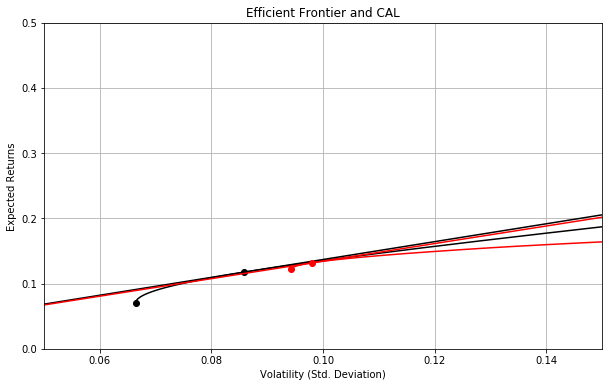

In [407]:
plt.figure(figsize=(10,6))    #更改圖的大小
x = np.linspace(0, 0.3, 1000)
plt.xlim(0.05,0.15)    #更改圖中x之範圍
plt.ylim(0.0,0.5)          #更改圖中y之範圍
plt.plot(x, sharpe_ratio_s*x,'k')  
plt.plot(risks_s, returns_s, 'k')
plt.plot(minvar_sdp_s, minvar_rp_s, 'ko') #min variance portfolio with shortsale  
plt.plot(sharpe_sdp_s, sharpe_rp_s, 'ko') #min sharpe ratio portfolio with shortsale

plt.plot(x, sharpe_ratio_n*x,'r')  
plt.plot(risks_n, returns_n, 'r')
plt.plot(minvar_sdp_n, minvar_rp_n, 'ro') #min variance portfolio without shortsale
plt.plot(sharpe_sdp_n, sharpe_rp_n, 'ro') #min sharpe ratio portfolio without shortsale

plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier and CAL')
plt.grid()

plt.show()

# Part 3: TB model

In [373]:
#The beta of each stock + yuanda50
returns_annual = pd.Series([0.18,
0.12,
0.15,
0.11,
0.09,
0.03])   ##Note: 自行輸入expected returns
returns_annual = returns_annual - 0.007   ##Note: 自行輸入expected risk free rate
num_assets = len(returns_annual)
print("Number of assets: ",num_assets)  #Note check the nomber of assets

BetaList = BetaList + [1]


Number of assets:  6


In [374]:
#The Cov matrix
listoflists = []
for i in range(num_assets):
    sublist = []
    for j in range(num_assets):
        if i ==j:
            sublist.append(ExcessMonthlyReturn.iloc[:,i].var())
        else:
            sublist.append(BetaList[i]*BetaList[j]*sigma_m_square)
    listoflists.append(sublist)

IndexMonthlyCovMatrix = pd.DataFrame(listoflists)
IndexYearlyCovMatrix = IndexMonthlyCovMatrix*12
IndexYearlyCovMatrix.to_csv('CovMatrix.csv')
IndexYearlyCovMatrix

,0,1,2,3,4,5
0,0.0336995664,0.0002507504,0.0002080723,-0.0000974732,-0.0001699525,0.0005885488
1,0.0002507504,0.0655269320,0.0014339447,-0.0006717431,-0.0011712394,0.0040560248
2,0.0002080723,0.0014339447,0.0739053485,-0.0005574114,-0.0009718927,0.0033656833
3,-0.0000974732,-0.0006717431,-0.0005574114,0.0414010874,0.0004552910,-0.0015766818
4,-0.0001699525,-0.0011712394,-0.0009718927,0.0004552910,0.0329997369,-0.0027490745
5,0.0005885488,0.0040560248,0.0033656833,-0.0015766818,-0.0027490745,0.0095200985


In [375]:
#Max sharpe ratio - short sale
expected_return = returns_annual.tolist()
maxSharpe_s = findMaxSharpeRatioPortfolio(expected_return,IndexYearlyCovMatrix,0,True)
sharpe_rp_s, sharpe_sdp_s = calcPortfolioPerf(maxSharpe_s['x'], expected_return, IndexYearlyCovMatrix)

sharpe_ratio_s = sharpe_rp_s / sharpe_sdp_s

print("The max sharpe ratio is",sharpe_ratio_s)
print("The expected return is",sharpe_rp_s)
print("")
for i in maxSharpe_s['x']:
     print('%.015f' % i)

The max sharpe ratio is 1.368933386069405
The expected return is 0.11756889797046122

0.319776372342733
0.101477900373873
0.116342556132883
0.162888826950557
0.174620303223537
0.124894040976417


In [376]:
#Min variance - short sale
portfolios_s, returns_s, risks_s, minvar_portfolio_s = efficient_frontier_and_min_var(returns_annual,IndexYearlyCovMatrix,True)
minvar_rp_s, minvar_sdp_s = calcPortfolioPerf(minvar_portfolio_s, expected_return, IndexYearlyCovMatrix)

print("The min sd is : ", minvar_sdp_s)
print("The return is : ",minvar_rp_s)
print(" ")
#for i in minvar_portfolio_s:
#    print('%.015f' % i)

The min sd is :  0.06641690702488263
The return is :  0.07030826522481867
 


In [378]:
#portfolio maxSharpe_s['x']  (shortsale)
MaxSharpe_potfolio_s = np.concatenate([[sharpe_rp_s],[sharpe_sdp_s],[sharpe_ratio_s],maxSharpe_s['x']])
MinVariance_portfolio_s = np.concatenate([[minvar_rp_s],[minvar_sdp_s],[minvar_rp_s/minvar_sdp_s],maxSharpe_s['x']])

pd.set_option('precision',10)
GivenReturnList = [0.10, 0.20, 0.30, 0.50, 0.60, 0.70,0.80]
l =[]
for i in range(len(GivenReturnList)):  
    GivenReturn = GivenReturnList[i]   
    portfolio = GivenReturnMinVarPort(GivenReturn, returns_annual,IndexYearlyCovMatrix,True)  #####
    portfolio_rp, portfolio_sdp = calcPortfolioPerf(portfolio, expected_return, IndexYearlyCovMatrix)
    sharpe = portfolio_rp/portfolio_sdp
    column = [portfolio_rp, portfolio_sdp, sharpe] + portfolio.tolist()
    l.append(column)

data=pd.DataFrame(l).T
data.insert(0, "MinVariance", MinVariance_portfolio_s)  #####
data.insert(2, "Optimum", MaxSharpe_potfolio_s)
data

,MinVariance,0,Optimum,1,2,3,4,5,6
0,0.0703082652,0.1000000000,0.1175688980,0.2000000000,0.3000000000,0.5000000000,0.6000000000,0.7000000000,0.8000001570
1,0.0664169070,0.0747088986,0.0858835785,0.1635163105,0.2728392245,0.5122140716,0.6548521232,0.8067519073,0.9748535102
2,1.0585898738,1.3385286335,1.3689333861,1.2231195740,1.0995486466,0.9761543616,0.9162373897,0.8676769075,0.8206362788
3,0.3197763723,0.2465916920,0.3197763723,0.6630484248,1.0795051830,1.4999994633,1.4999997947,1.4999999405,1.5540002233
4,0.1014779004,0.0785086584,0.1014779004,0.2092664731,0.3400242803,0.7641031283,1.0590156997,1.4333782745,1.5540001652
5,0.1163425561,0.0876814460,0.1163425561,0.2509062514,0.4141310634,0.9345305273,1.2936034574,1.4999981415,1.5540002037
6,0.1628888270,0.1487951900,0.1628888270,0.2289951024,0.3091949996,0.6568461426,0.9261305934,1.2840406509,1.5540001077
7,0.1746203032,0.1753346370,0.1746203032,0.1713399224,0.1673451624,0.3089907379,0.4560959243,0.6712155863,1.5539997804
8,0.1248940410,0.2630883766,0.1248940410,-0.5235561741,-1.3102006887,-3.1644699994,-4.2348454695,-5.3886325936,-6.7699966231


In [379]:
data.to_csv('Portfolios.csv')

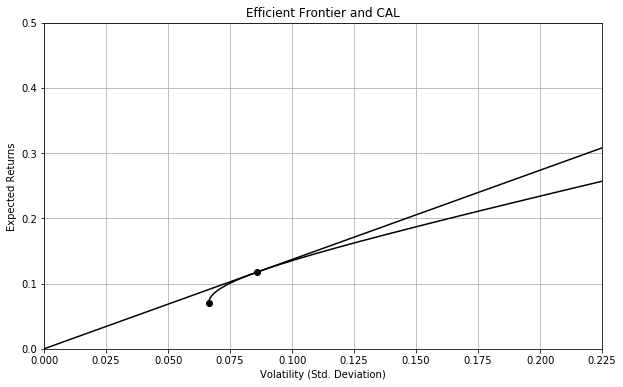

In [380]:
#figure
plt.figure(figsize=(10,6))    #更改圖的大小
x = np.linspace(0, 0.5, 1000)
plt.xlim(0,0.225)    #更改圖中x之範圍
plt.ylim(0.0,0.5)          #更改圖中y之範圍
plt.plot(x, sharpe_ratio_s*x,'k')  
plt.plot(risks_s, returns_s, 'k')
plt.plot(minvar_sdp_s, minvar_rp_s, 'ko') #min variance portfolio with shortsale
plt.plot(sharpe_sdp_s, sharpe_rp_s, 'ko') #min sharpe ratio portfolio with shortsale

plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier and CAL')
plt.grid()

plt.show()

## TB model officially starts here!

### Step 1: compute $w^0_i$ within the active portfolio A

In [381]:
#Alpha
AlphaList = [0]*num_assets
for i in range(num_assets):
    AlphaList[i] = returns_annual[i] - BetaList[i]*returns_annual.tolist()[-1]  #因為returns_annua是pd series所以用.tolist()轉成list
AlphaList

[0.17157810052661718,
 0.10320088187647597,
 0.13486870646437155,
 0.10680917079666158,
 0.0896416027521823,
 0.0]

In [382]:
#YearlySeSquare (firm-specific risk)
YearlySeSquareList = [i * 12 for i in SeSquareList]
for i in range(len(YearlySeSquareList)):
    print(YearlySeSquareList[i])

0.034243581000941006
0.06489884879382898
0.07396917821709023
0.0418492731854036
0.03276117359693037


In [383]:
#AlphaToFirmRisk
AlphaToFirmRisk = [(x*1.0)/y for x, y in zip(AlphaList, YearlySeSquareList)]
AlphaToFirmRisk

[5.010518628933763,
 1.5901804699853013,
 1.8233095150597571,
 2.5522347860969545,
 2.7362146379451273]

In [384]:
#wi_0
wi_0 = [i/sum(AlphaToFirmRisk) for i in AlphaToFirmRisk]
wi_0

[0.3653990127109933,
 0.11596611384889308,
 0.13296737244367254,
 0.1861252577050959,
 0.19954224329134504]

In [385]:
#wi_0_square
wi_0_square = [ i**2 for i in wi_0]
wi_0_square

[0.13351643849016864,
 0.01344813956121443,
 0.01768032213457433,
 0.03464261155578836,
 0.03981710685774233]

### Step 2: compute  $\alpha_A =\sum_{i=1}^{6}w^0_i\alpha_i $,   $\sigma^2(e_A) = \sum_{i=1}^{6}(w^0_i)^2\sigma^2(e_i)$

In [386]:
# Alpha和wi_0的內積
Alpha_A = sum([x*y for x, y in zip(AlphaList,wi_0)])
Alpha_A

0.13036258222088978

In [387]:
#YearlySeSquareList和wi_0_square的內積
Sigma_eA_square = sum([x*y for x, y in zip(YearlySeSquareList,wi_0_square)])
Sigma_eA_square

0.009506871915992737

### Step 3: compute  $w^0_A = \frac{\alpha_A/\sigma^2(e_A)}{E(R_M)/\sigma^2_M}$

In [388]:
#here we denote wA0 it as wA_0
wA_0 = (Alpha_A/Sigma_eA_square) / (returns_annual.tolist()[-1]/IndexYearlyCovMatrix.iloc[-1,-1])
wA_0

5.675823962563161

In [389]:
#Information ratio 
InfoRatio = Alpha_A**2 / Sigma_eA_square
InfoRatio

1.787591438432001

### Step4: compute $w^*_A = \frac{W^0_A}{1+(1-\beta_A)W^0_A}$

In [390]:
#beta_A
beta_A = sum([x*y for x, y in zip(wi_0,BetaList[:-1])])  #因為我們在最後一項放了market portfolio的beta值(1)所以要扣掉
beta_A

0.030559123447332283

In [391]:
#wA_star
wA_star = wA_0 / ( 1 + ( 1 - beta_A)* wA_0)
wA_star

0.8728846462127686

### Step5: compute $w_i^* = w_A^*w_i^0$

In [392]:
wi_star = [wA_star*i for i in wi_0]
print("wi_star:  ", wi_star)

w_market = 1 - wA_star
print("wm_star: ", w_market)

wi_star:   [0.31895118793673033, 0.10122504025966068, 0.11606517785333655, 0.162465879723173, 0.17417736043986792]
wm_star:  0.12711535378723138


### (12) Benchmark risk: $\sigma(T_E) = w_A\sqrt{(1-\beta_A)^2\sigma_M^2 + \sigma(e_A)^2)}$

In [396]:
BenchMarkRisk = wA_star*((1-beta_A)**2*(ExcessMonthlyReturn.iloc[:,-1].var()*12)+ Sigma_eA_square)**0.5
BenchMarkRisk

0.11857748092685687

### (13) Setting benchmark risk 

In [397]:
SetBenchMark = 0.05   ##Change this number to get risk-controlled market portfolio
wA_CtrlBenchMark = SetBenchMark / ((1-beta_A)**2*(ExcessMonthlyReturn.iloc[:,-1].var()*12)+ Sigma_eA_square)**0.5
wi_star_CtrlBenchMark = [i*wA_CtrlBenchMark for i in wi_0]
wM_CtrlBenchMark = 1 - wA_CtrlBenchMark

print("wM: ", wM_CtrlBenchMark)
print("wA:  ", wA_CtrlBenchMark)
print("wi  : ",wi_star_CtrlBenchMark)

wM:  0.6319349005435537
wA:   0.3680650994564463
wi  :  [0.13449062395475903, 0.0426830792273704, 0.04894064916294267, 0.06850621148858281, 0.07344453562279131]


### (14) Assuming A = 10 

In [404]:
A = 10
Investment = 1000000
p_RiskPremium =  wM_CtrlBenchMark*returns_annual.tolist()[-1] + wA_CtrlBenchMark*(beta_A*returns_annual.tolist()[-1] + Alpha_A)
sigma_p_square = ((wM_CtrlBenchMark+wA_CtrlBenchMark*beta_A)**2)*IndexYearlyCovMatrix.iloc[-1,-1] + wA_CtrlBenchMark**2*Sigma_eA_square
y_star = p_RiskPremium /(A*sigma_p_square)
w_rf = 1 - y_star
w_stock = [y_star*i for i in wi_star_CtrlBenchMark]

print("Y Star: ", y_star)
print("wi: ")
for i in range(len(w_stock)):
    print(w_stock[i])

print("Deposit:     ", w_rf)
print("Investment: ", y_star)



Y Star:  1.2011558617173819
wi: 
0.16154420130928693
0.05126903081010337
0.058785347618322464
0.0822866374935619
0.08821833447442684
Deposit:      -0.20115586171738187
Investment:  1.2011558617173819


In [405]:
A = 2
Investment = 1000000
p_RiskPremium =  wM_CtrlBenchMark*returns_annual.tolist()[-1] + wA_CtrlBenchMark*(beta_A*returns_annual.tolist()[-1] + Alpha_A)
sigma_p_square = ((wM_CtrlBenchMark+wA_CtrlBenchMark*beta_A)**2)*IndexYearlyCovMatrix.iloc[-1,-1] + wA_CtrlBenchMark**2*Sigma_eA_square
y_star = p_RiskPremium /(A*sigma_p_square)
w_rf = 1 - y_star
w_stock = [y_star*i for i in wi_star_CtrlBenchMark]

print("Y Star: ", y_star)
print("wi: ")
for i in range(len(w_stock)):
    print(w_stock[i])

print("Deposit:     ", w_rf)
print("Investment: ", y_star)

Y Star:  6.005779308586909
wi: 
0.8077210065464346
0.2563451540505169
0.29392673809161235
0.41143318746780944
0.4410916723721342
Deposit:      -5.005779308586909
Investment:  6.005779308586909


### (15) Change the Alpha 

In [329]:
#Change the Alpha here
AlphaList = [ i*0.1 for i in AlphaList]

#Just copying
AlphaToFirmRisk = [(x*1.0)/y for x, y in zip(AlphaList, YearlySeSquareList)]
wi_0 = [i/sum(AlphaToFirmRisk) for i in AlphaToFirmRisk]
wi_0_square = [ i**2 for i in wi_0]
Alpha_A = sum([x*y for x, y in zip(AlphaList,wi_0)])
Sigma_eA_square = sum([x*y for x, y in zip(YearlySeSquareList,wi_0_square)])
wA_0 = (Alpha_A/Sigma_eA_square) / (returns_annual.tolist()[-1]/IndexYearlyCovMatrix.iloc[-1,-1])
beta_A = sum([x*y for x, y in zip(wi_0,BetaList[:-1])])
wA_star = wA_0 / ( 1 + ( 1 - beta_A)* wA_0)
wi_star = [wA_star*i for i in wi_0]
w_market = 1 - wA_star
wi_star

[0.09666313964964478,
 0.030677829626398735,
 0.03517536513306063,
 0.049237822632279174,
 0.05278716980149732,
 0.02404181842083521,
 0.016490249594962637,
 0.26629213437965277]